In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.metrics import r2_score

In [4]:
np.random.seed(101)

In [5]:
def interval(df, diff):
    height = np.array(df)
    m = round(1 + np.log2(len(height)))
    h = (np.max(height) - np.min(height)) / m
    interval = [np.min(height) - diff]
    for k in range(1, m + 2):
        interval = np.append(interval, interval[k - 1] + h)
    interval_1 = interval[1::]
    interval_2 = interval[:-1]
    height = sorted(height)
    abs_freq_var = [0] * (m + 1)
    i = 0
    for k in range(len(height)):
        for j in range(len(interval_1)):
            if (height[k] > interval_2[j] and height[k] < interval_1[j]):
                abs_freq_var[j] += 1

    var_series_2 = pd.DataFrame([interval_2, interval_1])
    rel_freq_var = np.array(abs_freq_var) / len(df)
    var_series_2 = var_series_2.T
    var_series_2.columns = ['left', 'right']
    var_series_2 = var_series_2.join(
        [pd.Series(abs_freq_var, name='abs_freq').T, pd.Series(rel_freq_var, name='rel_freq').T])
    return var_series_2, interval_1, interval_2, h

# **Нормальное распределение**

In [6]:
# Генерация нормального распределения
# np.random.seed(111)
norm1 = []
norm2 = []
norm3 = []
for i in range(100):
    unif_1 = np.random.uniform(low=0.0, high=1.0, size=5000)
    norm1.append(sum(unif_1))
for i in range(15):
    unif_2 = np.random.uniform(low=0.0, high=1.0, size=5000)
    norm2.append(sum(unif_2))
for i in range(30):
    unif_3 = np.random.uniform(low=0.0, high=1.0, size=5000)
    norm3.append(sum(unif_3))

In [7]:
def chi2_pearson_norm(df1, df2):
    mean = np.mean(np.array(df1))
    std = np.std(np.array(df1))
    df2['Pi'] = (stats.norm.cdf((df2['right'] - mean) / std) - 0.5 - (
                stats.norm.cdf((df2['left'] - mean) / std) - 0.5)) * len(df1)
    chi2 = (((df2['abs_freq'] - df2['Pi']) ** 2) / df2['Pi']).sum()
    if chi2 < stats.chi2.ppf(0.95, len(df2) - 3):
        return 'norm', df2, chi2, stats.chi2.ppf(0.95, len(df2) - 3)
    else:
        return 'not norm'

## K = 10

In [8]:
var, int1, int2, h = interval(pd.DataFrame(norm1), diff=0.01)

In [9]:
if chi2_pearson_norm(norm1, var) != 'not norm':
    _, df_orig, _, _ = chi2_pearson_norm(norm1, var)
    df_orig[['left', 'right']] = df_orig[['left', 'right']].round(2)
    df_norm = df_orig.copy()
else:
    df_orig = None
    df_norm = None
    pass

In [10]:
chi2_pearson_norm(norm1, var)

('norm',
       left    right  abs_freq  rel_freq         Pi
 0  2457.86  2467.51         5      0.05   2.676890
 1  2467.51  2477.17         6      0.06   7.519592
 2  2477.17  2486.82        16      0.16  15.094066
 3  2486.82  2496.48        20      0.20  21.746991
 4  2496.48  2506.13        25      0.25  22.399769
 5  2506.13  2515.79        13      0.13  16.561710
 6  2515.79  2525.44        11      0.11   8.753167
 7  2525.44  2535.10         3      0.03   3.320150
 8  2535.10  2544.76         1      0.01   0.899986,
 4.204417536317303,
 12.591587243743977)

In [11]:
interval_hist = list(map(str, np.array([x for x in zip(np.round(int2, 2), np.round(int1, 2))])))
interval_hist = [x.replace(']', '') for x in interval_hist]
interval_hist = [x.replace('[', '') for x in interval_hist]

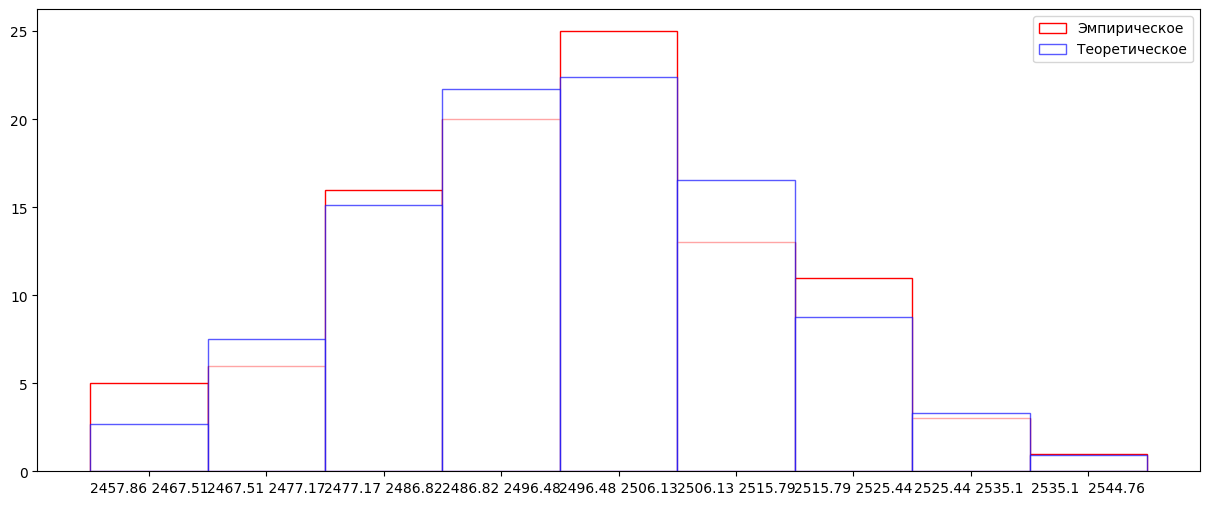

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.bar(int1, var['abs_freq'], width=h, edgecolor='r', tick_label=interval_hist, color='w', label='Эмпирическое')
ax.bar(int1, df_norm['Pi'], width=h, edgecolor='b', tick_label=interval_hist, color='w', alpha=0.65,
       label='Теоретическое')
plt.legend()
plt.show()

In [24]:
anamorf = pd.DataFrame(np.log(df_norm['rel_freq']))

In [25]:
anamorf['mean_int'] = ((var['right'] + var['left']) / 2)
anamorf['x'] = (anamorf['mean_int'] - np.array(norm1).mean()) ** 2
anamorf

,rel_freq,mean_int,x
0,-1.609438,2470.605,685.239223
1,-2.302585,2485.390,129.779359
2,-0.693147,2500.175,11.511944
3,-2.302585,2514.960,330.436980
4,-2.302585,2529.740,1086.224861


In [26]:
X = np.array(anamorf['x'])
y = np.array(anamorf['rel_freq'])

In [27]:
X_new = np.c_[X, np.ones(np.shape(X)[0])]
W = np.linalg.inv(X_new.T @ X_new) @ X_new.T @ y

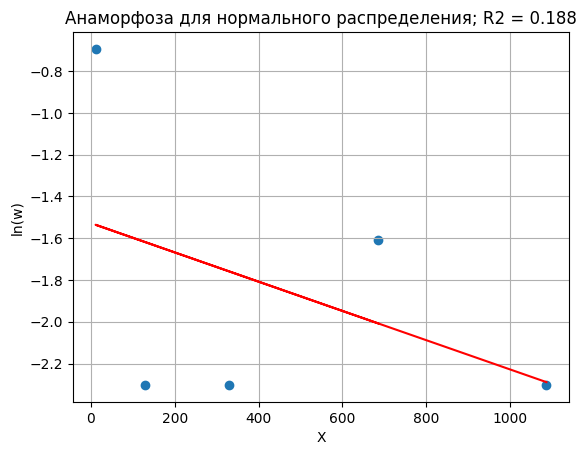

<Figure size 500x500 with 0 Axes>

In [28]:
fig, ax = plt.subplots()
plt.figure(figsize=(5, 5))
ax.grid()
ax.scatter(X, y)
ax.plot(X, X_new @ W, color='r')
ax.set_xlabel("X")
ax.set_ylabel("ln(w)")
ax.set_title(f'Анаморфоза для нормального распределения; R2 = {r2_score(y, X_new @ W).round(3)}')
plt.show()

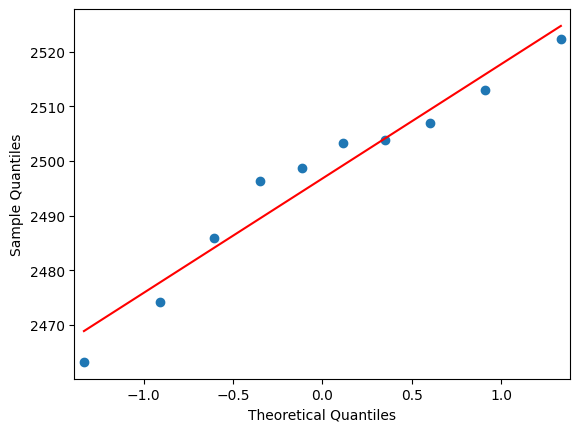

In [31]:
import statsmodels.api as sm

#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(np.array(norm1), line='r')
plt.show()

## K = 15

In [32]:
np.random.seed(100)

In [33]:
var, int1, int2, h = interval(pd.DataFrame(norm2), diff=0.01)

In [34]:
if chi2_pearson_norm(norm2, var) != 'not norm':
    _, df_orig, _, _ = chi2_pearson_norm(norm2, var)
    df_orig[['left', 'right']] = df_orig[['left', 'right']].round(2)
    df_norm = df_orig.copy()
else:
    df_orig = None
    df_norm = None
    pass

In [35]:
chi2_pearson_norm(norm2, var)

('norm',
       left    right  abs_freq  rel_freq        Pi
 0  2471.58  2481.36         2  0.133333  1.105075
 1  2481.36  2491.14         1  0.066667  2.572361
 2  2491.14  2500.92         5  0.333333  3.842480
 3  2500.92  2510.71         2  0.133333  3.687564
 4  2510.71  2520.49         4  0.266667  2.266071
 5  2520.49  2530.27         1  0.066667  0.894526,
 4.146018378906751,
 7.814727903251179)

In [36]:
interval_hist = list(map(str, np.array([x for x in zip(np.round(int2, 2), np.round(int1, 2))])))
interval_hist = [x.replace(']', '') for x in interval_hist]
interval_hist = [x.replace('[', '') for x in interval_hist]

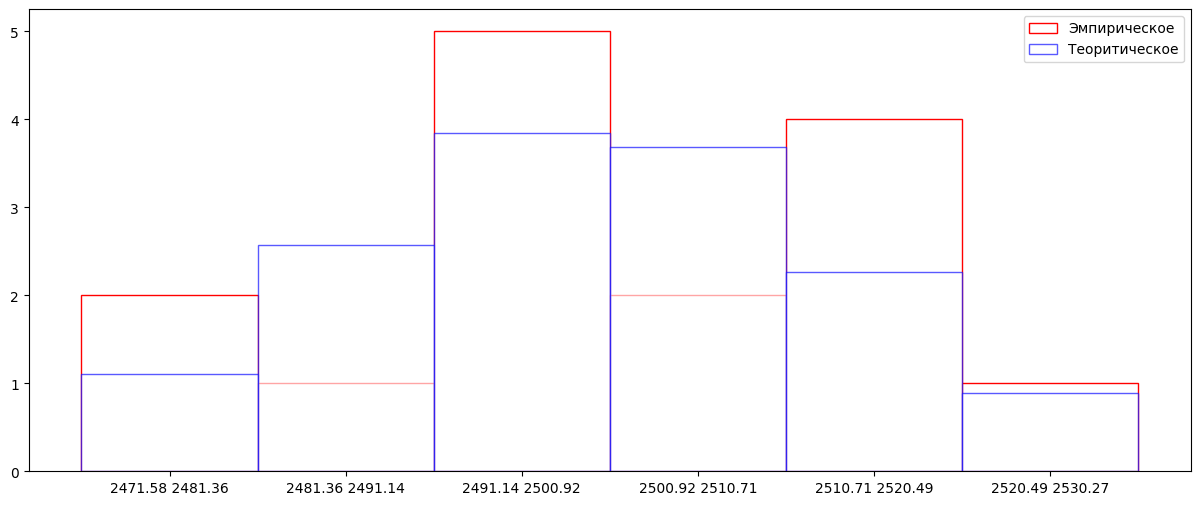

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.bar(int1, var['abs_freq'], width=h, edgecolor='r', tick_label=interval_hist, color='w', label='Эмпирическое')
ax.bar(int1, df_norm['Pi'], width=h, edgecolor='b', tick_label=interval_hist, color='w', alpha=0.65,
       label='Теоретическое')
plt.legend()
plt.show()

In [38]:
anamorf = pd.DataFrame(np.log(df_norm['rel_freq']))

In [39]:
anamorf['mean_int'] = ((var['right'] + var['left']) / 2)
anamorf['x'] = (anamorf['mean_int'] - np.array(norm2).mean()) ** 2
anamorf

,rel_freq,mean_int,x
0,-2.014903,2476.470,553.339426
1,-2.708050,2486.250,188.874663
2,-1.098612,2496.030,15.706699
3,-2.014903,2505.815,33.893730
4,-1.321756,2515.600,243.573210
5,-2.708050,2525.380,644.491246


In [40]:
X = np.array(anamorf['x'])
y = np.array(anamorf['rel_freq'])

In [41]:
X_new = np.c_[X, np.ones(np.shape(X)[0])]
W = np.linalg.inv(X_new.T @ X_new) @ X_new.T @ y

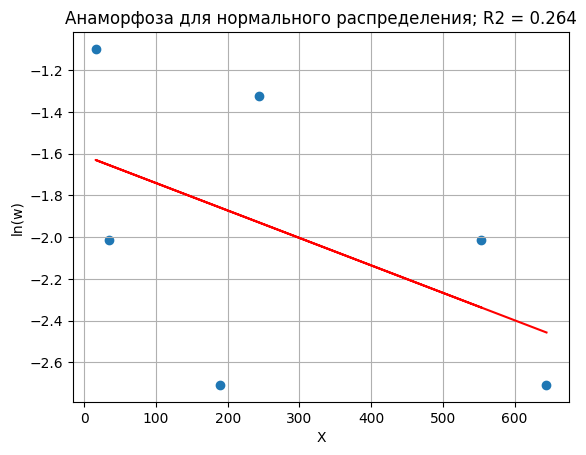

<Figure size 500x500 with 0 Axes>

In [42]:
fig, ax = plt.subplots()
plt.figure(figsize=(5, 5))
ax.grid()
ax.scatter(X, y)
ax.plot(X, X_new @ W, color='r')
ax.set_xlabel("X")
ax.set_ylabel("ln(w)")
ax.set_title(f'Анаморфоза для нормального распределения; R2 = {r2_score(y, X_new @ W).round(3)}')
plt.show()

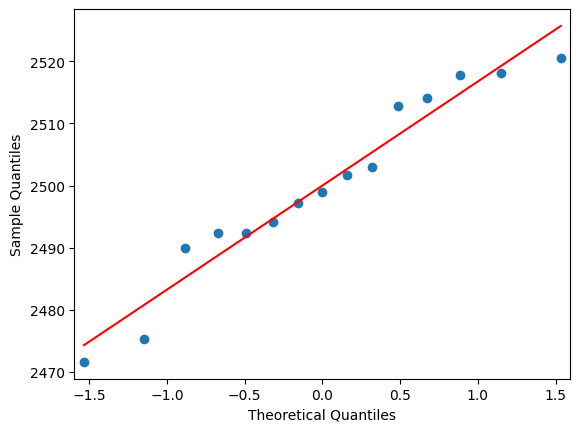

In [43]:
#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(np.array(norm2), line='r')
plt.show()

## K = 30

In [44]:
var, int1, int2, h = interval(pd.DataFrame(norm3), diff=0.01)

In [45]:
if chi2_pearson_norm(norm3, var) != 'not norm':
    _, df_orig, _, _ = chi2_pearson_norm(norm3, var)
    df_orig[['left', 'right']] = df_orig[['left', 'right']].round(2)
    df_norm = df_orig.copy()
else:
    df_orig = None
    df_norm = None
    pass

In [46]:
chi2_pearson_norm(norm3, var)

('norm',
       left    right  abs_freq  rel_freq        Pi
 0  2457.86  2468.67         2  0.066667  1.481857
 1  2468.67  2479.49         3  0.100000  4.297324
 2  2479.49  2490.30        11  0.366667  7.580615
 3  2490.30  2501.12         6  0.200000  8.169648
 4  2501.12  2511.93         5  0.166667  5.360016
 5  2511.93  2522.75         2  0.066667  2.147727
 6  2522.75  2533.56         1  0.033333  0.523056,
 3.160647494285087,
 9.487729036781154)

In [47]:
interval_hist = list(map(str, np.array([x for x in zip(np.round(int2, 2), np.round(int1, 2))])))
interval_hist = [x.replace(']', '') for x in interval_hist]
interval_hist = [x.replace('[', '') for x in interval_hist]

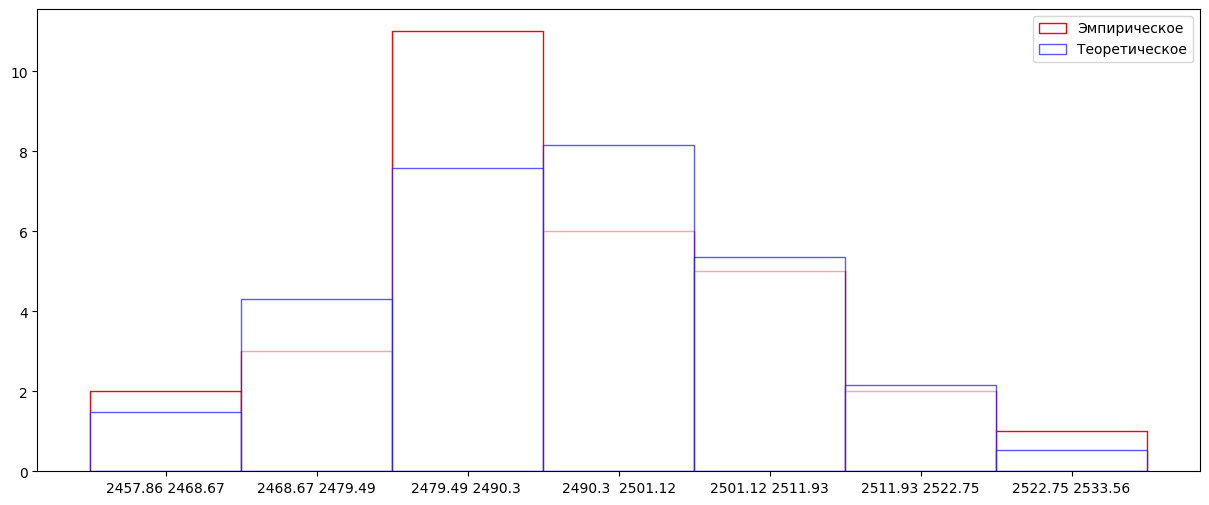

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.bar(int1, var['abs_freq'], width=h, edgecolor='r', tick_label=interval_hist, color='w', label='Эмпирическое')
ax.bar(int1, df_norm['Pi'], width=h, edgecolor='b', tick_label=interval_hist, color='w', alpha=0.65,
       label='Теоретическое')
plt.legend()
plt.show()

In [49]:
anamorf = pd.DataFrame(np.log(df_norm['rel_freq']))

In [50]:
anamorf['mean_int'] = ((var['right'] + var['left']) / 2)
anamorf['x'] = (anamorf['mean_int'] - np.array(norm3).mean()) ** 2
anamorf

,rel_freq,mean_int,x
0,-2.708050,2463.265,821.098753
1,-2.302585,2474.080,318.259205
2,-1.003302,2484.895,49.348107
3,-1.609438,2495.710,14.365459
4,-1.791759,2506.525,213.311260
5,-2.708050,2517.340,646.185512
6,-3.401197,2528.155,1312.988214


In [51]:
X = np.array(anamorf['x'])
y = np.array(anamorf['rel_freq'])

In [52]:
X_new = np.c_[X, np.ones(np.shape(X)[0])]
W = np.linalg.inv(X_new.T @ X_new) @ X_new.T @ y

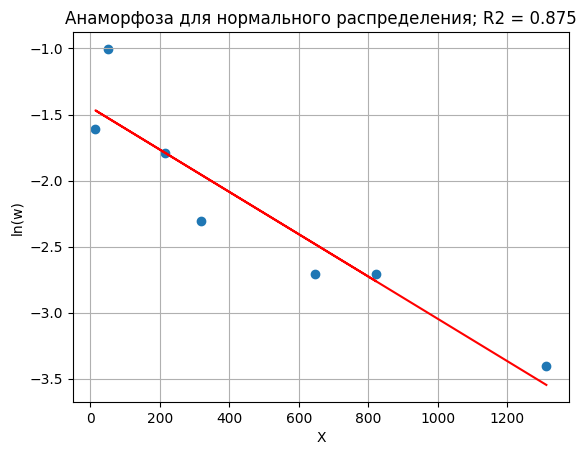

<Figure size 500x500 with 0 Axes>

In [53]:
fig, ax = plt.subplots()
plt.figure(figsize=(5, 5))
ax.grid()
ax.scatter(X, y)
ax.plot(X, X_new @ W, color='r')
ax.set_xlabel("X")
ax.set_ylabel("ln(w)")
ax.set_title(f'Анаморфоза для нормального распределения; R2 = {r2_score(y, X_new @ W).round(3)}')
plt.show()

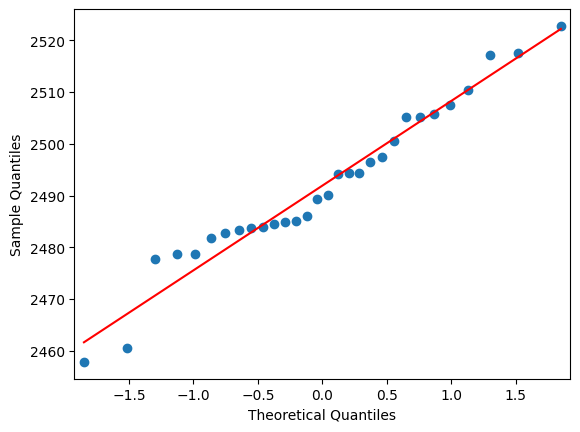

In [54]:
import statsmodels.api as sm

#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(np.array(norm3), line='r')
plt.show()

# **Хи-квадрат**

In [37]:
norm3

[2528.42758737196,
 2519.1710463404265,
 2504.031234288263,
 2496.273023109793,
 2508.1175130042325,
 2482.980595565772,
 2523.372714988997,
 2463.4516900237627,
 2487.3264185540006,
 2501.339597082346,
 2475.7494770461526,
 2526.7925483525755,
 2468.3662625968454,
 2509.3765615610755,
 2498.461568252582,
 2526.3798432764615,
 2499.944948109016,
 2529.2647004816167,
 2511.0385468941286,
 2506.550392675241,
 2437.544240566054,
 2508.781537720646,
 2519.2680144433334,
 2493.5352758728695,
 2500.37301674244,
 2539.931565543139,
 2502.2787439236095,
 2504.451775099889,
 2502.4790259667484,
 2474.3095390484273]

In [38]:
chi2_1

[array([1.03335085e-01, 6.51493848e-01, 1.95895804e+00, 2.43763985e+00,
        1.35124993e+00, 1.30727361e+00, 1.49565496e-02, 1.80312041e-01,
        7.73550929e-01, 3.60922087e-04, 2.34745987e+00, 6.83234862e-01,
        5.41256687e-02, 7.01333797e+00, 1.50329545e-03, 1.49346104e-01,
        2.94622915e-02, 5.71078151e-01, 1.13352626e+00, 5.55708857e-01,
        2.19296077e+00, 3.21068422e+00, 2.80660425e+00, 4.54701975e-03,
        5.54941888e-02, 2.48109572e+00, 2.44402503e+00, 1.57749884e+00,
        2.82125501e-01, 7.30840177e-01, 9.37283829e-03, 2.41764597e-01,
        4.34294718e-01, 6.04025179e-01, 2.44076653e+00, 5.61268246e-01,
        4.18278736e-02, 2.22981411e-02, 4.83895958e-01, 3.09914954e-01,
        1.96661912e-01, 5.42020333e-01, 1.67645801e-03, 9.53795150e-01,
        8.20552113e-01, 7.62305526e-04, 4.64000726e-01, 1.33596486e+00,
        1.27349806e+00, 1.16575006e-01, 4.71523759e-01, 2.45432164e-02,
        1.18768759e+00, 1.86712262e-01, 9.76478069e-02, 1.723915

In [39]:
chi2_2

[array([3.96578260e-01, 1.71039558e-01, 2.97725292e-02, 1.25961591e+00,
        4.68772208e+00, 1.40351627e+00, 3.08056123e+00, 1.26151318e-01,
        3.06350044e-04, 3.69281606e-03, 1.01941415e+00, 7.18354584e-02,
        1.81100382e-02, 2.26583004e+00, 6.65067363e-02, 1.69979364e+00,
        7.83817822e+00, 2.50660867e-01, 2.17305362e-01, 9.68028344e-01,
        3.00656609e+00, 1.30449851e-01, 4.85560155e-01, 2.32075178e+00,
        2.43339959e-03, 4.74388959e-01, 4.77832919e-01, 2.73120364e-01,
        1.82710207e-01, 3.72158900e-01, 7.72913633e-01, 2.36395521e-01,
        3.99853826e-02, 1.01950755e+00, 1.05972213e-01, 1.32526503e+00,
        2.59160578e-01, 6.33230652e-03, 4.38551622e-03, 1.05761055e+00,
        1.02184415e+00, 6.03407310e-04, 3.87842469e+00, 3.01237340e-01,
        4.43189150e-02, 1.28327944e-01, 2.69263517e+00, 2.13224058e+00,
        9.81195445e-01, 8.71088569e+00, 8.63195937e-03, 3.98111389e-03,
        1.60028400e+00, 6.03200983e-01, 4.28668508e+00, 3.185094

In [15]:
#Хи-квадрат
np.random.seed(110)
chi2_1 = []
deg_fre_chi_1 = 2
chi2_2 = []
deg_fre_chi_2 = 4
chi2_3 = []
deg_fre_chi_3 = 16
for i in range(deg_fre_chi_1):
    z1 = np.random.normal(5, 10, size=1000)
    p1 = (z1 - np.mean(z1)) / np.std(z1)
    pp2 = pow(p1, 2)
    chi2_1.append(pp2)
chi2_fin_1 = np.sum(chi2_1, axis=0)
for i in range(deg_fre_chi_2):
    z2 = np.random.normal(5, 10, size=1000)
    p2 = (z2 - np.mean(z2)) / np.std(z2)
    pp2 = pow(p2, 2)
    chi2_2.append(pp2)
chi2_fin_2 = np.sum(chi2_2, axis=0)
for i in range(deg_fre_chi_3):
    z3 = np.random.normal(5, 10, size=1000)
    p3 = (z3 - np.mean(z3)) / np.std(z3)
    pp2 = pow(p3, 2)
    chi2_3.append(pp2)
chi2_fin_3 = np.sum(chi2_3, axis=0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


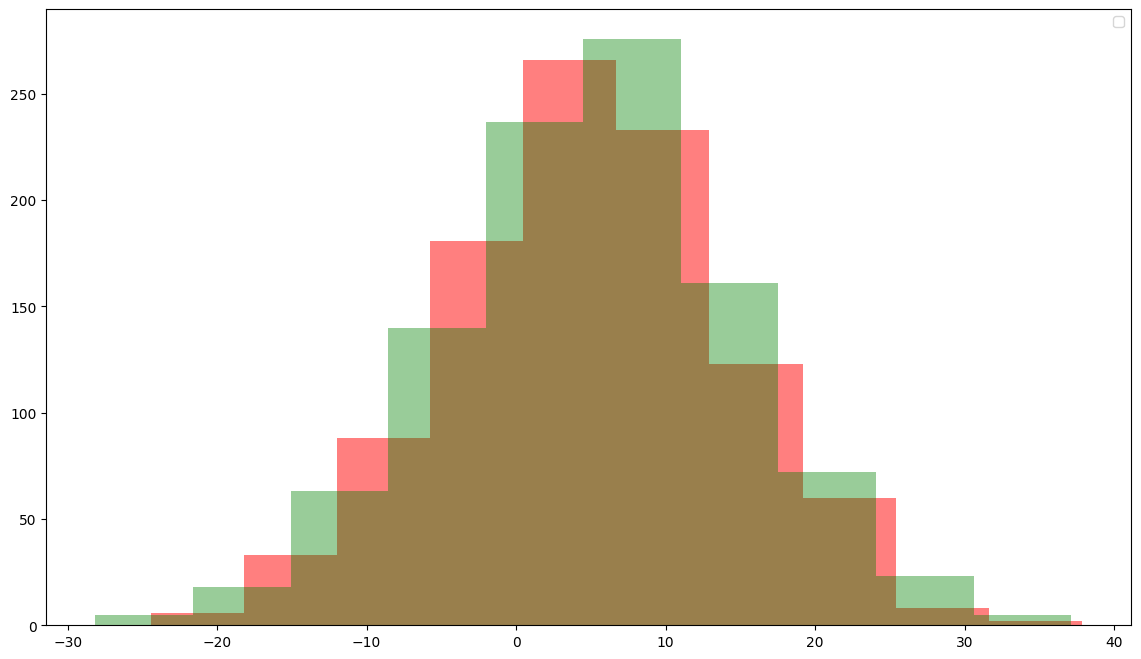

In [16]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(14, 8)
ax.hist(z1, alpha=0.5, color='r')
ax.hist(z2, alpha=0.4, color='g')
plt.legend()
plt.show()

In [17]:
def chi2_pearson_chi2(df1, df2, k):
    mean = np.mean(np.array(df1))
    std = np.std(np.array(df1))
    df2['Pi'] = (stats.chi2.cdf(df2['right'], k) - stats.chi2.cdf(df2['left'], k)) * sum(df2['abs_freq'])
    chi2 = (((df2['abs_freq'] - df2['Pi']) ** 2) / df2['Pi']).sum()
    if chi2 < stats.chi2.ppf(0.95, len(df2) - 2):
        return 'yes', df2, chi2, stats.chi2.ppf(0.95, len(df2) - 2)
    else:
        return 'no', df2, chi2, stats.chi2.ppf(0.95, len(df2) - 2)

## K = 2

In [18]:
var, int1, int2, h = interval(pd.DataFrame(chi2_fin_1), diff=1e-2)

In [19]:
if chi2_pearson_chi2(chi2_fin_1, var, deg_fre_chi_1) != 'chinet':
    _, df_orig, _, _ = chi2_pearson_chi2(chi2_fin_1, var, deg_fre_chi_1)
    df_orig[['left', 'right']] = df_orig[['left', 'right']].round(2)
    df_chi2 = df_orig.copy()
else:
    df_orig = None
    df_chi2 = None
    pass

In [20]:
chi2_pearson_chi2(chi2_fin_1, var, deg_fre_chi_1)

('yes',
      left  right  abs_freq  rel_freq          Pi
 0   -0.01   1.39       508     0.508  500.925552
 1    1.39   2.79       239     0.239  251.241412
 2    2.79   4.19       127     0.127  124.762793
 3    4.19   5.58        64     0.064   61.649030
 4    5.58   6.98        36     0.036   30.920342
 5    6.98   8.38         9     0.009   15.354587
 6    8.38   9.78         7     0.007    7.624862
 7    9.78  11.18         4     0.004    3.786395
 8   11.18  12.57         3     0.003    1.870971
 9   12.57  13.97         1     0.001    0.938394
 10  13.97  15.37         1     0.001    0.465993
 11  15.37  16.77         1     0.001    0.231405,
 8.2039010795553,
 18.307038053275146)

In [21]:
df_chi2

,left,right,abs_freq,rel_freq,Pi
0,-0.01,1.39,508,0.508,500.779341
1,1.39,2.79,239,0.239,251.065485
2,2.79,4.19,127,0.127,124.800923
3,4.19,5.58,64,0.064,62.036685
4,5.58,6.98,36,0.036,30.837515
5,6.98,8.38,9,0.009,15.328871
6,8.38,9.78,7,0.007,7.619754
7,9.78,11.18,4,0.004,3.787666
8,11.18,12.57,3,0.003,1.882793
9,12.57,13.97,1,0.001,0.935908


In [22]:
interval_hist = list(map(str, np.array([x for x in zip(np.round(int2, 2), np.round(int1, 2))])))
interval_hist = [x.replace(']', '') for x in interval_hist]
interval_hist = [x.replace('[', '') for x in interval_hist]

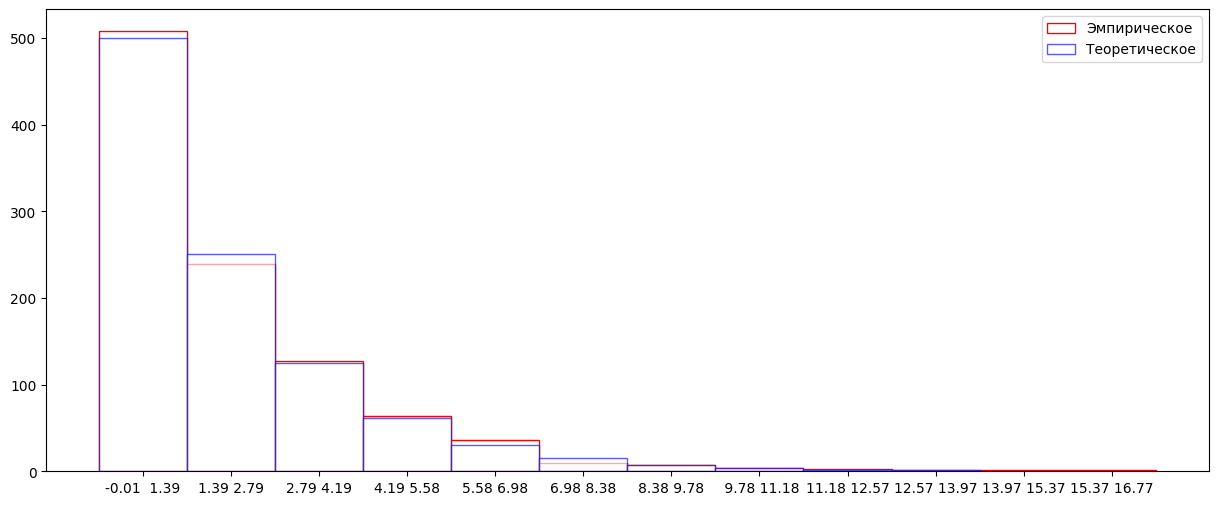

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.bar(int1, var['abs_freq'], width=h, edgecolor='r', tick_label=interval_hist, color='w', label='Эмпирическое')
ax.bar(int1, df_chi2['Pi'], width=h, edgecolor='b', tick_label=interval_hist, color='w', alpha=0.65,
       label='Теоретическое')
plt.legend()
plt.show()

In [40]:
import statsmodels.api as sm

#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(chi2_1, line='r')
plt.show()

AttributeError: 'list' object has no attribute 'shape'

## K = 4

In [25]:
var_2, int1, int2, h = interval(pd.DataFrame(chi2_fin_2), diff=1e-2)

In [26]:
if chi2_pearson_chi2(chi2_fin_2, var_2, deg_fre_chi_2) != 'chinet':
    _, df_orig, _, _ = chi2_pearson_chi2(chi2_fin_2, var_2, deg_fre_chi_2)
    df_orig[['left', 'right']] = df_orig[['left', 'right']].round(2)
    df_chi2_2 = df_orig.copy()
else:
    df_orig = None
    df_chi2 = None
    pass

In [27]:
chi2_pearson_chi2(chi2_fin_2, var_2, deg_fre_chi_2)

('yes',
      left  right  abs_freq  rel_freq          Pi
 0    0.07   1.49       177     0.177  170.990252
 1    1.49   2.90       256     0.256  253.714148
 2    2.90   4.31       203     0.203  209.022639
 3    4.31   5.73       132     0.132  145.434765
 4    5.73   7.14        89     0.089   91.567551
 5    7.14   8.55        64     0.064   55.286194
 6    8.55   9.96        35     0.035   32.279163
 7    9.96  11.38        24     0.024   18.497417
 8   11.38  12.79        11     0.011   10.260671
 9   12.79  14.20         4     0.004    5.665456
 10  14.20  15.62         4     0.004    3.109502
 11  15.62  17.03         1     0.001    1.666669,
 6.022598335705661,
 18.307038053275146)

In [28]:
interval_hist = list(map(str, np.array([x for x in zip(np.round(int2, 2), np.round(int1, 2))])))
interval_hist = [x.replace(']', '') for x in interval_hist]
interval_hist = [x.replace('[', '') for x in interval_hist]

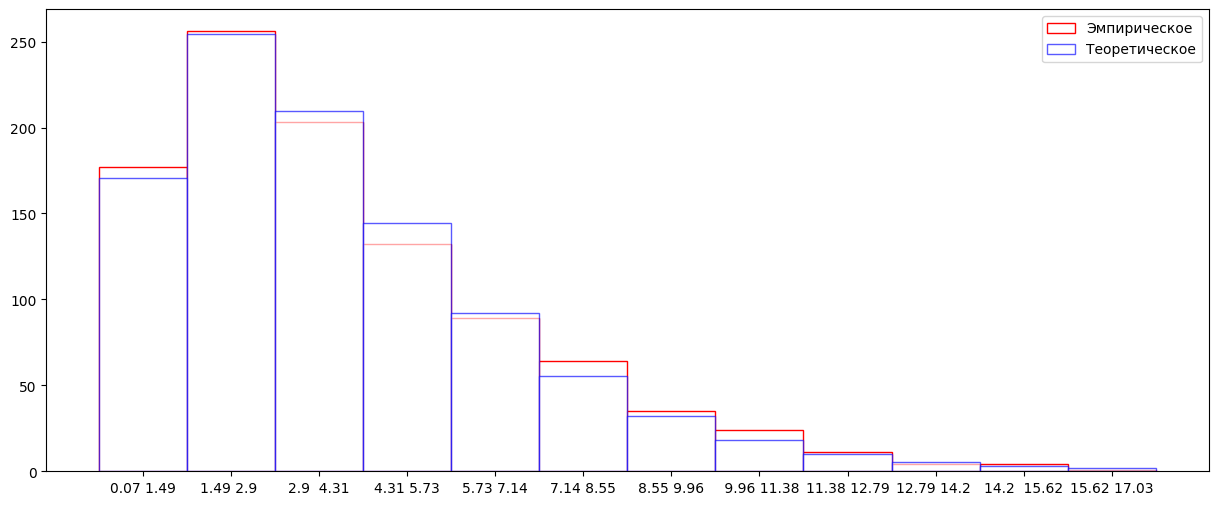

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.bar(int1, var_2['abs_freq'], width=h, edgecolor='r', tick_label=interval_hist, color='w', label='Эмпирическое')
ax.bar(int1, df_chi2_2['Pi'], width=h, edgecolor='b', tick_label=interval_hist, color='w', alpha=0.65,
       label='Теоретическое')
plt.legend()
plt.show()

## K = 16

In [30]:
var_3, int1, int2, h = interval(pd.DataFrame(chi2_fin_3), diff=1e-2)

In [31]:
if chi2_pearson_chi2(chi2_fin_3, var_3, deg_fre_chi_3) != 'chinet':
    _, df_orig, _, _ = chi2_pearson_chi2(chi2_fin_3, var_3, deg_fre_chi_3)
    df_orig[['left', 'right']] = df_orig[['left', 'right']].round(2)
    df_chi2_3 = df_orig.copy()
else:
    df_orig = None
    df_chi2 = None
    pass

In [32]:
chi2_pearson_chi2(chi2_fin_3, var_3, deg_fre_chi_3)

('yes',
      left  right  abs_freq  rel_freq          Pi
 0    4.78   7.82        48     0.048   42.698027
 1    7.82  10.86       144     0.144  136.001973
 2   10.86  13.90       187     0.187  211.879620
 3   13.90  16.94       224     0.224  216.673612
 4   16.94  19.97       175     0.175  167.915042
 5   19.97  23.01       104     0.104  108.107433
 6   23.01  26.05        65     0.065   60.138681
 7   26.05  29.09        30     0.030   29.992486
 8   29.09  32.13        15     0.015   13.719044
 9   32.13  35.17         4     0.004    5.850456
 10  35.17  38.20         3     0.003    2.349726
 11  38.20  41.24         1     0.001    0.905314,
 6.040609163296643,
 18.307038053275146)

In [33]:
interval_hist = list(map(str, np.array([x for x in zip(np.round(int2, 2), np.round(int1, 2))])))
interval_hist = [x.replace(']', '') for x in interval_hist]
interval_hist = [x.replace('[', '') for x in interval_hist]

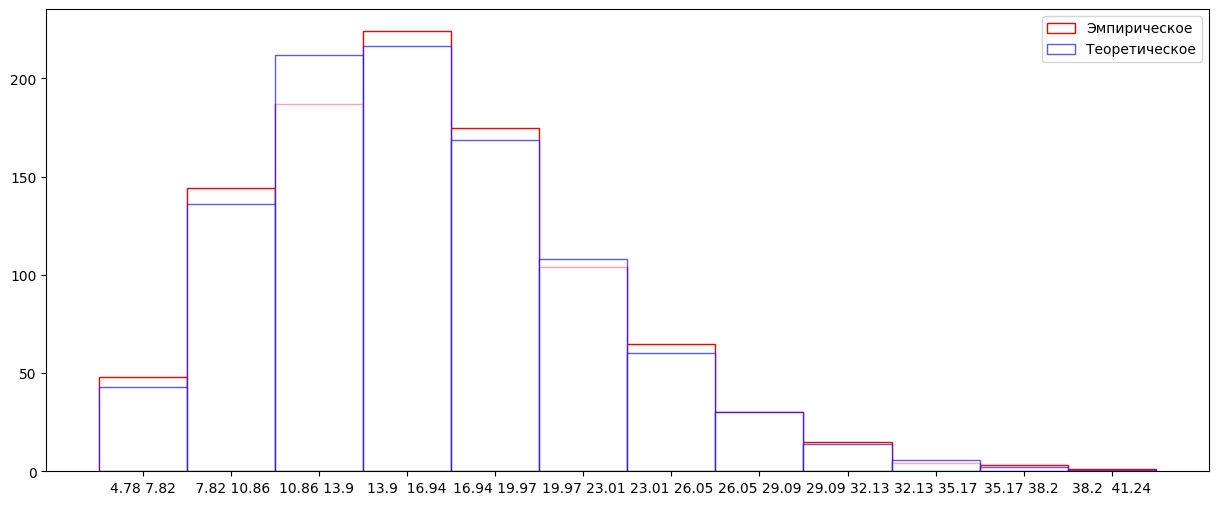

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.bar(int1, var_3['abs_freq'], width=h, edgecolor='r', tick_label=interval_hist, color='w', label='Эмпирическое')
ax.bar(int1, df_chi2_3['Pi'], width=h, edgecolor='b', tick_label=interval_hist, color='w', alpha=0.65,
       label='Теоретическое')
plt.legend()
plt.show()

# **Фишер**

In [77]:
#Фишер
np.random.seed(110)
d1 = 5
d2 = 15
y1 = np.random.chisquare(d1, 1000)
y2 = np.random.chisquare(d2, 1000)
fisher = (y1 / d1) / (y2 / d2)

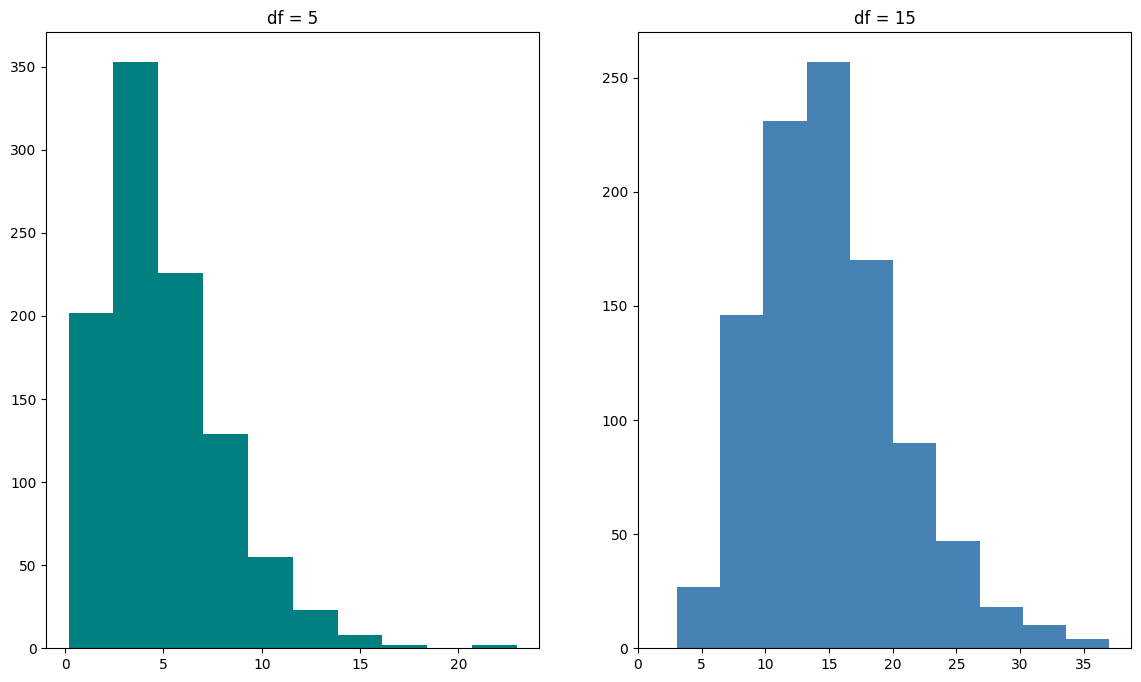

In [78]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(14, 8)
ax[0].hist(y1, color='teal')
ax[0].set_title('df = 5')
ax[1].hist(y2, color='steelblue')
ax[1].set_title('df = 15')
plt.xlim(0)
plt.show()

In [80]:
def chi2_pearson_fisher(df2, dn, dd):
    df2['Pi'] = (stats.f.cdf(df2['right'], dfn=dn, dfd=dd) - stats.f.cdf(df2['left'], dfn=dn, dfd=dd)) * sum(
        df2['abs_freq'])
    fis = (((df2['abs_freq'] - df2['Pi']) ** 2) / df2['Pi']).sum()
    if fis < stats.chi2.ppf(0.95, len(df2) - 3):
        return 'fisher', df2, fis, stats.chi2.ppf(0.95, len(df2) - 3)
    else:
        return ('Not fisher', stats.chi2.ppf(0.95, len(df2) - 3), fis)

In [81]:
var, int1, int2, h = interval(pd.DataFrame(fisher), diff=0.01)

In [82]:
chi2_pearson_fisher(var, d1, d2)

('fisher',
         left     right  abs_freq  rel_freq          Pi
 0   0.027842  0.787257       433     0.433  424.791420
 1   0.787257  1.546672       342     0.342  340.129475
 2   1.546672  2.306087       129     0.129  138.317527
 3   2.306087  3.065502        56     0.056   54.271748
 4   3.065502  3.824917        19     0.019   22.412004
 5   3.824917  4.584332         7     0.007    9.875398
 6   4.584332  5.343746         8     0.008    4.632129
 7   5.343746  6.103161         2     0.002    2.298932
 8   6.103161  6.862576         2     0.002    1.199462
 9   6.862576  7.621991         0     0.000    0.654023
 10  7.621991  8.381406         1     0.001    0.370769
 11  8.381406  9.140821         1     0.001    0.217568,
 9.765811867351385,
 16.918977604620448)

In [83]:
if chi2_pearson_fisher(var, d1, d2) != 'No fisher':
    _, df_orig, _, _ = chi2_pearson_fisher(var, d1, d2)
    df_orig[['left', 'right']] = df_orig[['left', 'right']].round(2)
    df_fisher = df_orig.copy()
else:
    df_orig = None
    df_fisher = None
    pass

In [84]:
interval_hist = list(map(str, np.array([x for x in zip(np.round(int2, 2), np.round(int1, 2))])))
interval_hist = [x.replace(']', '') for x in interval_hist]
interval_hist = [x.replace('[', '') for x in interval_hist]

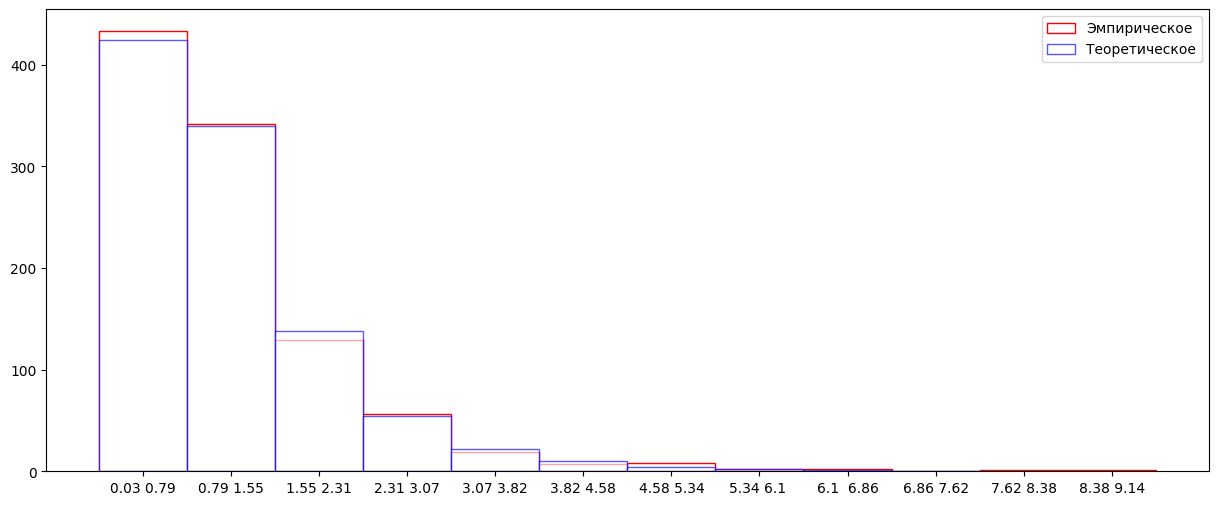

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.bar(int1, var['abs_freq'], width=h, edgecolor='r', tick_label=interval_hist, color='w', label='Эмпирическое')
ax.bar(int1, df_fisher['Pi'], width=h, edgecolor='b', tick_label=interval_hist, color='w', alpha=0.65,
       label='Теоретическое')
plt.legend()
plt.show()

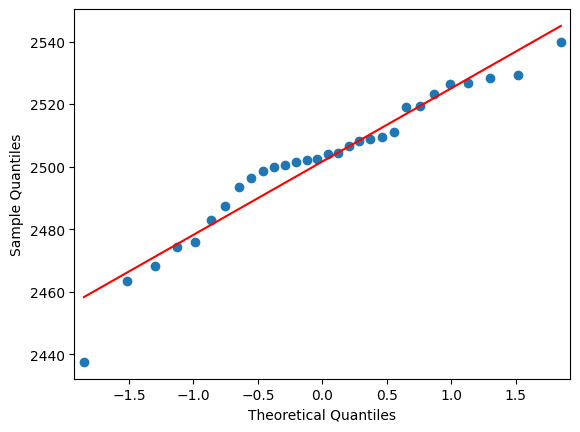

In [35]:
import statsmodels.api as sm

#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(np.array(norm3), line='r')
plt.show()

# **t-распределение**

In [86]:
#t-распределение
np.random.seed(10)
y = []
k = 4
for i in range(k):
    y.append(np.random.normal(0, 1, 1000))
y0 = np.random.normal(0, 1, 1000)
t = y0 / np.sqrt((np.sum(np.power(y, 2), axis=0)) / k)

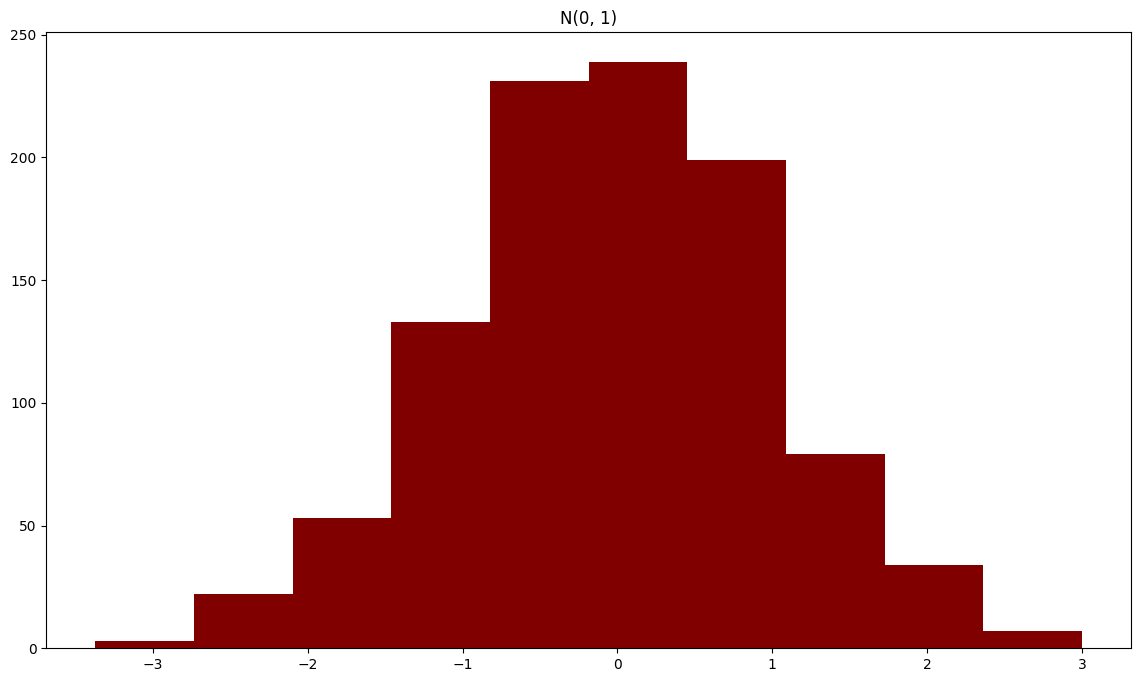

In [87]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(14, 8)
ax.hist(y0, color='maroon')
ax.set_title('N(0, 1)')
plt.show()

In [90]:
def chi2_pearson_t(df2, k):
    df2['Pi'] = (stats.t.cdf(df2['right'], k) - stats.t.cdf(df2['left'], k)) * sum(df2['abs_freq'])
    ts = (((df2['abs_freq'] - df2['Pi']) ** 2) / df2['Pi']).sum()
    if ts < stats.chi2.ppf(0.95, len(df2) - 2):
        return 't', df2
    else:
        return 'Not t', df2, ts, stats.chi2.ppf(0.95, len(df2) - 2)

In [91]:
var, int1, int2, h = interval(pd.DataFrame(t), diff=0.01)

In [92]:
if chi2_pearson_t(var, k) != 'Not t':
    _, df_orig = chi2_pearson_t(var, k)
    df_orig[['left', 'right']] = df_orig[['left', 'right']].round(2)
    df_t = df_orig.copy()
else:
    df_orig = None
    df_chi2 = None
    pass

In [93]:
chi2_pearson_t(var, k)

('t',
     left  right  abs_freq  rel_freq          Pi
 0  -8.62  -7.22         2     0.002    0.477985
 1  -7.22  -5.82         1     0.001    1.194096
 2  -5.82  -4.42         6     0.006    3.585517
 3  -4.42  -3.02        17     0.017   13.826173
 4  -3.02  -1.62        76     0.076   70.691849
 5  -1.62  -0.22       334     0.334  328.047973
 6  -0.22   1.18       410     0.410  429.987257
 7   1.18   2.58       121     0.121  121.027587
 8   2.58   3.98        25     0.025   22.463154
 9   3.98   5.38         6     0.006    5.316244
 10  5.38   6.78         1     0.001    1.649213
 11  6.78   8.18         1     0.001    0.626926)

In [94]:
interval_hist = list(map(str, np.array([x for x in zip(np.round(int2, 2), np.round(int1, 2))])))
interval_hist = [x.replace(']', '') for x in interval_hist]
interval_hist = [x.replace('[', '') for x in interval_hist]

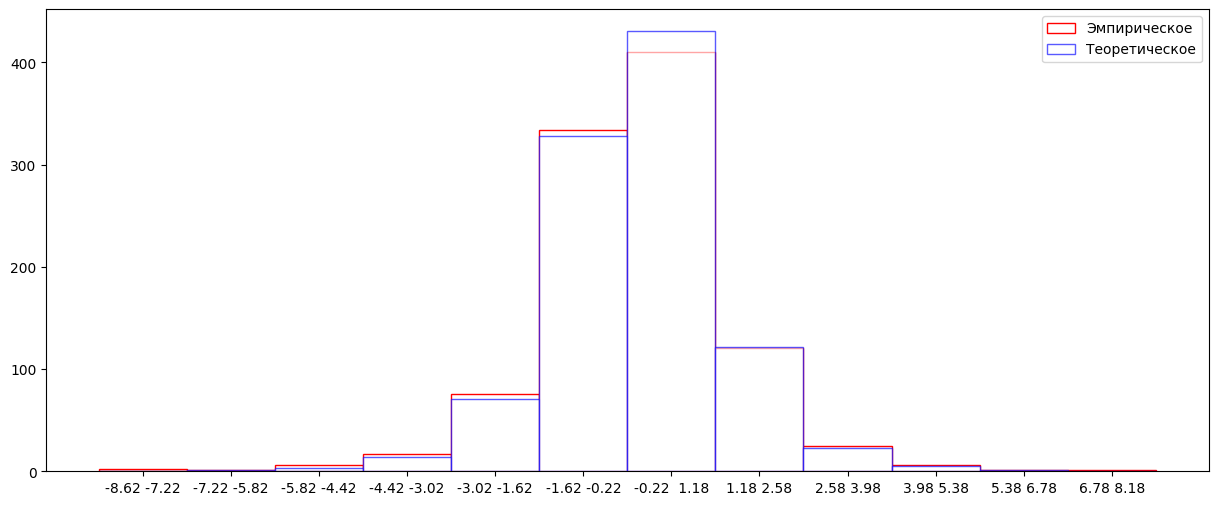

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.bar(int1, var['abs_freq'], width=h, edgecolor='r', tick_label=interval_hist, color='w', label='Эмпирическое')
ax.bar(int1, df_t['Pi'], width=h, edgecolor='b', tick_label=interval_hist, color='w', alpha=0.65, label='Теоретическое')
plt.legend()
plt.show()